# Task 1-2 (improvement for Task1.ipynb)

Please train a model to predict the results of matches in test.csv. The output format is the sample in sample_submission.csv

I change a Data preprocess method from Task1.ipynb.

## Importing Libraries.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

/var/folders/r8/__hqjl2n5j5_wf6w5j15gn300000gn/T/ipykernel_15425/3844507630.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./train.csv")


## Data Pre-process.

In [43]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [46]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                            & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                            & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0,
                                                                                                inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [47]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id',
                   'home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [48]:
def convert_to_long_form(df, feature_columns, history_columns):
    '''coverting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [49]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')
        
        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')
        
    return df

In [50]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [55]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference 
    for each previous match, and the average points got, average goal scored, average goal conceded 
    and average goal difference up to that match as previous n-match form'''
    
    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']
    
    home_team_history_goal_info_available=df.groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_history_goal_info_available.to_frame(name='home_team_history_goal_info_available'), on='id')
    away_team_history_goal_info_available=df.groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_history_goal_info_available.to_frame(name='away_team_history_goal_info_available'), on='id')
    home_team_history_rating_info_available=df.groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_history_rating_info_available.to_frame(name='home_team_history_rating_info_available'), 
               on='id')
    away_team_history_rating_info_available=df.groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_history_rating_info_available.to_frame(name='away_team_history_rating_info_available'), 
               on='id')
    
        
    for i in [5,10]:
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), 
                   on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(
            name=f'home_team_history_average_goal_conceded_{i}'), on='id')
        
        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), 
                   on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'),
                   on='id')
        
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        
        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')
        
        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')
    
    home_team_home_form_average_goal_scored=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal.mean()
    df=df.join(home_team_home_form_average_goal_scored.to_frame(name='home_team_home_form_average_goal_scored'), on='id')
    home_team_home_form_average_goal_conceded=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_opponent_goal.mean()
    df=df.join(home_team_home_form_average_goal_conceded.to_frame(name='home_team_home_form_average_goal_conceded'), on='id')
    home_team_home_form_average_goal_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.mean()
    df=df.join(home_team_home_form_average_goal_difference.to_frame(name='home_team_home_form_average_goal_difference'), on='id')
    home_team_home_form_goal_difference_std=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.std()
    df=df.join(home_team_home_form_goal_difference_std.to_frame(name='home_team_home_form_goal_difference_std'), on='id')
    home_team_home_form_win_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==3)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_win_rate.to_frame(name='home_team_home_form_win_rate'), on='id')
    home_team_home_form_draw_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==1)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_draw_rate.to_frame(name='home_team_home_form_draw_rate'), on='id')
    home_team_home_form_lose_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==0)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_lose_rate.to_frame(name='home_team_home_form_lose_rate'), on='id')
    home_team_home_form_average_point=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_point.mean()
    df=df.join(home_team_home_form_average_point.to_frame(name='home_team_home_form_average_point'), on='id')
    home_team_home_form_median_rating_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.median()
    df=df.join(home_team_home_form_median_rating_difference.to_frame(name='home_team_home_form_median_rating_difference'), on='id')
    home_team_home_form_goal_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_home_form_goal_info_available.to_frame(name='home_team_home_form_goal_info_available'), on='id')
    home_team_home_form_rating_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_home_form_rating_info_available.to_frame(name='home_team_home_form_rating_info_available'), on='id')
    
    away_team_away_form_average_goal_scored=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal.mean()
    df=df.join(away_team_away_form_average_goal_scored.to_frame(name='away_team_away_form_average_goal_scored'), on='id')
    away_team_away_form_average_goal_conceded=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_opponent_goal.mean()
    df=df.join(away_team_away_form_average_goal_conceded.to_frame(name='away_team_away_form_average_goal_conceded'), on='id')
    away_team_away_form_average_goal_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.mean()
    df=df.join(away_team_away_form_average_goal_difference.to_frame(name='away_team_away_form_average_goal_difference'), on='id')
    away_team_away_form_goal_difference_std=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.std()
    df=df.join(away_team_away_form_goal_difference_std.to_frame(name='away_team_away_form_goal_difference_std'), on='id')
    away_team_away_form_win_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==3)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_win_rate.to_frame(name='away_team_away_form_win_rate'), on='id')
    away_team_away_form_draw_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==1)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_draw_rate.to_frame(name='away_team_away_form_draw_rate'), on='id')
    away_team_away_form_lose_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==0)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_lose_rate.to_frame(name='away_team_away_form_lose_rate'), on='id')
    away_team_away_form_average_point=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_point.mean()
    df=df.join(away_team_away_form_average_point.to_frame(name='away_team_away_form_average_point'), on='id')
    away_team_away_form_median_rating_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.median()
    df=df.join(away_team_away_form_median_rating_difference.to_frame(name='away_team_away_form_median_rating_difference'), on='id')
    away_team_away_form_goal_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_away_form_goal_info_available.to_frame(name='away_team_away_form_goal_info_available'), on='id')
    away_team_away_form_rating_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_away_form_rating_info_available.to_frame(name='away_team_away_form_rating_info_available'), on='id')
    
    return df

In [51]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals based on this'''
    
    home_history_columns=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id']
    home_history=df[home_history_columns]
    home_history=home_history.drop_duplicates()
    
    away_history_columns=['away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    away_history=df[away_history_columns]
    away_history=away_history.drop_duplicates()
    
    league_total_goal = home_history.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = home_history.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.count() 
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal=df.league_average_goal.fillna(df.league_average_goal.mean())
    
    league_total_home_goal = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    df.league_average_home_goal=df.league_average_home_goal.fillna(df.league_average_home_goal.mean())
    
    league_total_away_goal = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    df.league_average_away_goal=df.league_average_away_goal.fillna(df.league_average_away_goal.mean())
    
    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength
    
    
    #getting teams' record of goal scored and conceded in each league
    home_team_league_average_goal_scored=df.groupby(['id','home_team_history_league_id']).home_team_history_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_scored.columns=['id','league_id','home_team_league_average_goal_scored']
    df=pd.merge(df, home_team_league_average_goal_scored, how='left')
    
    home_team_league_average_goal_conceded=df.groupby(['id','home_team_history_league_id']).home_team_history_opponent_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_conceded.columns=['id','league_id','home_team_league_average_goal_conceded']
    df=pd.merge(df, home_team_league_average_goal_conceded, how='left')
    
    away_team_league_average_goal_scored=df.groupby(['id','away_team_history_league_id']).away_team_history_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_scored.columns=['id','league_id','away_team_league_average_goal_scored']
    df=pd.merge(df, away_team_league_average_goal_scored, how='left')
    
    away_team_league_average_goal_conceded=df.groupby(['id','away_team_history_league_id']).away_team_history_opponent_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_conceded.columns=['id','league_id','away_team_league_average_goal_conceded']
    df=pd.merge(df, away_team_league_average_goal_conceded, how='left')
    
    #setting another set of attack, defense and expected goal data based on team's record
    df['home_team_league_attack_strength'] = df.home_team_league_average_goal_scored/df.league_average_goal
    df['home_team_league_defense_strength'] = df.home_team_league_average_goal_conceded/df.league_average_goal
    df['away_team_league_attack_strength'] = df.away_team_league_average_goal_scored/df.league_average_goal
    df['away_team_league_defense_strength'] = df.away_team_league_average_goal_conceded/df.league_average_goal
    df['home_team_league_expected_goal'] = df.league_average_home_goal*df.home_team_league_attack_strength*df.away_team_league_defense_strength
    df['away_team_league_expected_goal'] = df.league_average_away_goal*df.away_team_league_attack_strength*df.home_team_league_defense_strength
    
    #getting coach's record of goal scored and conceded in each league
    home_coach_goal=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_goal']].dropna()
    home_coach_goal=home_coach_goal.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_goal2=home_coach_goal.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_goal2['home_team_coach_league_average_goal_scored']=(home_coach_goal2['cumsum'])/(home_coach_goal2['cumcount']+1)
    home_coach_goal3=home_coach_goal2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_scored']]
    home_coach_goal3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_scored']
    home_coach_goal3=home_coach_goal3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_goal3, how='left')
    
    home_coach_conceded=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_opponent_goal']].dropna()
    home_coach_conceded=home_coach_conceded.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_conceded2=home_coach_conceded.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_conceded2['home_team_coach_league_average_goal_conceded']=(home_coach_conceded2['cumsum'])/(home_coach_conceded2['cumcount']+1)
    home_coach_conceded3=home_coach_conceded2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_conceded']]
    home_coach_conceded3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_conceded']
    home_coach_conceded3=home_coach_conceded3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_conceded3, how='left')
    
    away_coach_goal=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_goal']].dropna()
    away_coach_goal=away_coach_goal.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_goal2=away_coach_goal.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_goal2['away_team_coach_league_average_goal_scored']=(away_coach_goal2['cumsum'])/(away_coach_goal2['cumcount']+1)
    away_coach_goal3=away_coach_goal2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_scored']]
    away_coach_goal3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_scored']
    away_coach_goal3=away_coach_goal3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_goal3, how='left')
    
    away_coach_conceded=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_opponent_goal']].dropna()
    away_coach_conceded=away_coach_conceded.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_conceded2=away_coach_conceded.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_conceded2['away_team_coach_league_average_goal_conceded']=(away_coach_conceded2['cumsum'])/(away_coach_conceded2['cumcount']+1)
    away_coach_conceded3=away_coach_conceded2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_conceded']]
    away_coach_conceded3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_conceded']
    away_coach_conceded3=away_coach_conceded3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_conceded3, how='left')
    
    #setting another set of attack, defense and expected goal data based on coach's record
    df['home_team_coach_attack_strength'] = df.home_team_coach_league_average_goal_scored/df.league_average_goal
    df['home_team_coach_defense_strength'] = df.home_team_coach_league_average_goal_conceded/df.league_average_goal
    df['away_team_coach_attack_strength'] = df.away_team_coach_league_average_goal_scored/df.league_average_goal
    df['away_team_coach_defense_strength'] = df.away_team_coach_league_average_goal_conceded/df.league_average_goal
    df['home_team_coach_expected_goal'] = df.league_average_home_goal*df.home_team_coach_attack_strength*df.away_team_coach_defense_strength
    df['away_team_coach_expected_goal'] = df.league_average_away_goal*df.away_team_coach_attack_strength*df.home_team_coach_defense_strength
    
    return df

In [52]:
def reshape(df):
    '''reshape the dataframe back to wide form'''
    history_columns=['home_team_history_is_play_home',
              'home_team_history_is_cup',
              'home_team_history_goal',
              'home_team_history_opponent_goal',
              'home_team_history_rating',
              'home_team_history_opponent_rating',
              'home_team_history_coach',
              'home_team_history_league_id',
              'home_team_history_goal_difference',
              'home_team_history_point',
              'home_team_history_rating_difference',
              'away_team_history_is_play_home',
              'away_team_history_is_cup',
              'away_team_history_goal',
              'away_team_history_opponent_goal',
              'away_team_history_rating',
              'away_team_history_opponent_rating',
              'away_team_history_coach',
              'away_team_history_league_id',
              'away_team_history_goal_difference',
              'away_team_history_point',
              'away_team_history_rating_difference']
    drop_columns=['match','match_date','home_team_history_match_date','away_team_history_match_date']
    df_history=df[history_columns+['id','match']].set_index(['id','match']).unstack(level=1)
    df_history.columns = df_history.columns.map('{0[0]}_{0[1]}'.format) 
    df_history=df_history.reset_index()
    df_new=df.groupby('id').first().reset_index().drop(history_columns+drop_columns, axis=1)
    df_new=df_new.merge(df_history, how='left')
    
    return df_new

In [53]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df=reshape(df)

    return df

In [56]:
train_p=preprocession(train)

In [57]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11864226
away_team_coach_id 458731.0
league_id 453
away_has_coach_change 0
home_has_coach_change 0
is_cup 0.0
home_team_coach_id 456984.0
home_team_history_match_interval_1 80.9375
away_team_history_match_interval_1 85.0625
home_team_history_match_interval_2 80.9375
away_team_history_match_interval_2 85.0625
home_team_history_match_interval_5 80.9375
away_team_history_match_interval_5 85.0625
home_team_history_goal_info_available 10
away_team_history_goal_info_available 10
home_team_history_rating_info_available 10
away_team_history_rating_info_available 10
home_team_history_average_goal_scored_5 1.6
home_team_history_average_goal_conceded_5 2.0
away_team_history_average_goal_scored_5 1.0
away_team_history_average_goal_conceded_5 1.6
home_team_history_average_goal_difference_5 -0.3999999999999999
away_team_history_average_goal_difference_5 -0.6000000000000001
home_team_history_average_point_5 1.4
away_team_history_average_point_5 0.8
home_team_history_average_point_std_5 1.516575088

In [58]:
train_p

id  away_team_coach_id  league_id  away_has_coach_change  \
0       11428294            257433.0        755                      0   
1       11428295          16476269.0        755                      0   
2       11428297            474745.0        755                      0   
3       11428298            472575.0        755                      0   
4       11428299            216631.0        755                      0   
...          ...                 ...        ...                    ...   
110933  18045358                 NaN        827                      0   
110934  18046139           1552546.0        974                      0   
110935  18046140          17905337.0        974                      0   
110936  18046141           2206663.0        974                      0   
110937  18053837                 NaN       1642                      0   

        home_has_coach_change  is_cup  home_team_coach_id  \
0                           1     0.0            468693.0   
1                           1     0.0          37331516.0   
2                           1     0.0            212710.0   
3                           0     0.0            186127.0   
4                           0     0.0            470514.0   
...                       ...     ...                 ...   
110933                      1     0.0                 NaN   
110934                      1     0.0          37568493.0   
110935                      0     0.0          22859379.0   
110936                      1     0.0          29328646.0   
110937                      0     0.0                 NaN   

        home_team_history_match_interval_1  \
0                                 6.083333   
1                                 4.000000   
2                                 3.916667   
3                                 4.083333   
4                                 3.000000   
...                                    ...   
110933                            4.083333   
110934                           56.906250   
110935                           57.135417   
110936                           56.208333   
110937                            7.000000   

        away_team_history_match_interval_1  \
0                                 5.083333   
1                                 4.083333   
2                                 6.000000   
3                                 3.000000   
4                                 4.000000   
...                                    ...   
110933                           11.104167   
110934                           61.000000   
110935                           57.031250   
110936                           57.218750   
110937                            7.000000   

        home_team_history_match_interval_2  ...  \
0                                 6.083333  ...   
1                                 4.000000  ...   
2                                 3.916667  ...   
3                                 4.083333  ...   
4                                 3.000000  ...   
...                                    ...  ...   
110933                            4.083333  ...   
110934                           56.906250  ...   
110935                           57.135417  ...   
110936                           56.208333  ...   
110937                            7.000000  ...   

        away_team_history_rating_difference_1  \
0                                   -1.686090   
1                                    4.695250   
2                                    1.019475   
3                                   11.564250   
4                                    1.934107   
...                                       ...   
110933                               0.357700   
110934                               2.292718   
110935                               5.968467   
110936                               2.012634   
110937                              -0.854287   

        away_team_history_rating_difference_2  \
0                                  

In [118]:
test_p=preprocession(test)

In [119]:
test_p

id  away_team_coach_id  league_id  away_has_coach_change  \
0      11913628           1565666.0        714                      0   
1      11913633           1565613.0        714                      0   
2      11913634          37570473.0        714                      0   
3      11913635           1565666.0        714                      0   
4      11913636            311388.0        714                      0   
...         ...                 ...        ...                    ...   
72706  18450343            458369.0       1393                      0   
72707  18450597                 NaN        857                      0   
72708  18450602          37369407.0        857                      0   
72709  18450640            524071.0        779                      0   
72710  18450641          37572009.0        779                      0   

       home_has_coach_change  is_cup  home_team_coach_id  \
0                          1       1          37570473.0   
1                          1       1            311388.0   
2                          1       1           8055515.0   
3                          1       1           1565613.0   
4                          1       1          37570473.0   
...                      ...     ...                 ...   
72706                      0       1          37346872.0   
72707                      0       0                 NaN   
72708                      0       0                 NaN   
72709                      0       0            524398.0   
72710                      0       0            261421.0   

       home_team_history_match_interval_1  away_team_history_match_interval_1  \
0                                8.104167                            2.916667   
1                                4.000000                            7.041667   
2                                3.875000                            4.000000   
3                              563.208333                           66.125000   
4                              558.020833                          529.177083   
...                                   ...                                 ...   
72706                            4.000000                            4.000000   
72707                            4.000000                            8.000000   
72708                            8.000000                            4.000000   
72709                            7.916667                            4.687500   
72710                            8.125000                            4.895833   

       home_team_history_match_interval_2  ...  \
0                                8.104167  ...   
1                                4.000000  ...   
2                                3.875000  ...   
3                              563.208333  ...   
4                              558.020833  ...   
...                                   ...  ...   
72706                            4.000000  ...   
72707                            4.000000  ...   
72708                            8.000000  ...   
72709                            7.916667  ...   
72710                            8.125000  ...   

       away_team_history_rating_difference_1  \
0                                   9.821486   
1                                  -9.821486   
2                                 -21.373595   
3                                  -8.468983   
4                                   5.905686   
...                                      ...   
72706                               7.220800   
72707                              -0.170433   
72708                               3.375237   
72709                              -3.890663   
72710                               2.572497   

       away_team_history_rating_difference_2  \
0                                  -8.468983   
1                                   6.103600   
2                                   8.494625   
3                                   0.310200   
4                       

In [59]:
X=train_p.drop('id', axis=1)
y=train.sort_values(by='id')['target']

In [60]:
X

away_team_coach_id  league_id  away_has_coach_change  \
0                 257433.0        755                      0   
1               16476269.0        755                      0   
2                 474745.0        755                      0   
3                 472575.0        755                      0   
4                 216631.0        755                      0   
...                    ...        ...                    ...   
110933                 NaN        827                      0   
110934           1552546.0        974                      0   
110935          17905337.0        974                      0   
110936           2206663.0        974                      0   
110937                 NaN       1642                      0   

        home_has_coach_change  is_cup  home_team_coach_id  \
0                           1     0.0            468693.0   
1                           1     0.0          37331516.0   
2                           1     0.0            212710.0   
3                           0     0.0            186127.0   
4                           0     0.0            470514.0   
...                       ...     ...                 ...   
110933                      1     0.0                 NaN   
110934                      1     0.0          37568493.0   
110935                      0     0.0          22859379.0   
110936                      1     0.0          29328646.0   
110937                      0     0.0                 NaN   

        home_team_history_match_interval_1  \
0                                 6.083333   
1                                 4.000000   
2                                 3.916667   
3                                 4.083333   
4                                 3.000000   
...                                    ...   
110933                            4.083333   
110934                           56.906250   
110935                           57.135417   
110936                           56.208333   
110937                            7.000000   

        away_team_history_match_interval_1  \
0                                 5.083333   
1                                 4.083333   
2                                 6.000000   
3                                 3.000000   
4                                 4.000000   
...                                    ...   
110933                           11.104167   
110934                           61.000000   
110935                           57.031250   
110936                           57.218750   
110937                            7.000000   

        home_team_history_match_interval_2  \
0                                 6.083333   
1                                 4.000000   
2                                 3.916667   
3                                 4.083333   
4                                 3.000000   
...                                    ...   
110933                            4.083333   
110934                           56.906250   
110935                           57.135417   
110936                           56.208333   
110937                            7.000000   

        away_team_history_match_interval_2  ...  \
0                                 5.083333  ...   
1                                 4.083333  ...   
2                                 6.000000  ...   
3                                 3.000000  ...   
4                                 4.000000  ...   
...                                    ...  ...   
110933                           11.104167  ...   
110934                           61.000000  ...   
110935                           57.031250  ...   
110936                           57.218750  ...   
110937                            7.000000  ...   

        away_team_history_rating_difference_1  \
0                                   -1.686090   
1                                    4.695250   
2                                    1.019475   
3                                   11

In [61]:
y

913       away
685       away
792       draw
686       away
664       away
          ... 
110565    draw
110662    away
110721    draw
110780    away
110733    away
Name: target, Length: 110938, dtype: object

In [62]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [63]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,
                    label_encoded_y, train_size=0.8, random_state=42)

<h3>Apply HistGradientBoostingClassifier</h3>

In [96]:
from sklearn.ensemble import HistGradientBoostingClassifier
classifier_hgb = HistGradientBoostingClassifier(random_state=42, max_depth=5)
                                    
classifier_hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=5, random_state=42)

In [98]:
from sklearn.metrics import accuracy_score , precision_score ,recall_score,confusion_matrix,classification_report
y_pred_train = classifier_hgb.predict(X_train)
y_pred_val = classifier_hgb.predict(X_valid)
test_accuracy = accuracy_score(y_valid, y_pred_val)

In [103]:
print("Confusion Matrix \n",confusion_matrix(y_valid,y_pred_val))
print("\n")
print("<-------------------Classification Report---------------------->\n") 
print(classification_report(y_valid,y_pred_val))
print("\n")
print("<---------------Accuracy Scores------------------->\n") #print('Train Accuracy score: ',train_accuracy)
print('Test Accuracy score:',test_accuracy)

Confusion Matrix 
 [[3356  164 3525]
 [1708  190 3622]
 [1878  192 7553]]


<-------------------Classification Report---------------------->

              precision    recall  f1-score   support

           0       0.48      0.48      0.48      7045
           1       0.35      0.03      0.06      5520
           2       0.51      0.78      0.62      9623

    accuracy                           0.50     22188
   macro avg       0.45      0.43      0.39     22188
weighted avg       0.46      0.50      0.44     22188



<---------------Accuracy Scores------------------->

Test Accuracy score: 0.500225347034433


In [104]:
 from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_hgb,
                           param_grid=params,verbose=1, scoring="accuracy")

In [105]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(max_depth=5,
                                                      random_state=42),
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [106]:
grid_search.best_score_

0.5036845070422535

In [107]:
rf_best = grid_search.best_estimator_
rf_best

HistGradientBoostingClassifier(max_depth=3, min_samples_leaf=50,
                               random_state=42)

In [108]:
classifier_hgb = HistGradientBoostingClassifier(max_depth=3, min_samples_leaf=50,
                               random_state=42)
                                    
classifier_hgb.fit(X_train, y_train)
y_pred_train = classifier_hgb.predict(X_train)
y_pred_val = classifier_hgb.predict(X_valid)
test_accuracy = accuracy_score(y_valid, y_pred_val)

In [123]:
print("Confusion Matrix \n",confusion_matrix(y_valid,y_pred_val))
print("\n")
print("<-------------------Classification Report---------------------->\n") 
print(classification_report(y_valid,y_pred_val))
print("\n")
print("<---------------Accuracy Scores------------------->\n")
print('Test Accuracy score:',test_accuracy)

Confusion Matrix 
 [[3348  146 3551]
 [1708  154 3658]
 [1843  141 7639]]


<-------------------Classification Report---------------------->

              precision    recall  f1-score   support

           0       0.49      0.48      0.48      7045
           1       0.35      0.03      0.05      5520
           2       0.51      0.79      0.62      9623

    accuracy                           0.50     22188
   macro avg       0.45      0.43      0.39     22188
weighted avg       0.46      0.50      0.44     22188



<---------------Accuracy Scores------------------->

Test Accuracy score: 0.5021182621236705


In [116]:
X_test=test_p.drop('id', axis=1)
output = classifier_hgb.predict_proba(X_test)
output.shape

(72711, 3)

Saving probabilites prediction into Task1_hgb_submission.csv

In [122]:
output_to_csv_hgb = pd.concat([test['id'], pd.DataFrame(output, columns=["Home","Draw","Away"])],axis=1).to_csv("./Task12_hgb_submission.csv")

<h3>Apply XGBoost</h3>

In [66]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [67]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.025,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.25,
    'alpha': 2,
    'lambda': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [68]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20)

/Users/quangtn/opt/anaconda3/envs/mc_challenge1/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.09581	eval-mlogloss:1.09601
[1]	train-mlogloss:1.09289	eval-mlogloss:1.09328
[2]	train-mlogloss:1.09021	eval-mlogloss:1.09077
[3]	train-mlogloss:1.08765	eval-mlogloss:1.08838
[4]	train-mlogloss:1.08516	eval-mlogloss:1.08609
[5]	train-mlogloss:1.08281	eval-mlogloss:1.08391
[6]	train-mlogloss:1.08033	eval-mlogloss:1.08166
[7]	train-mlogloss:1.07792	eval-mlogloss:1.07941
[8]	train-mlogloss:1.07562	eval-mlogloss:1.07732
[9]	train-mlogloss:1.07342	eval-mlogloss:1.07524
[10]	train-mlogloss:1.07129	eval-mlogloss:1.07326
[11]	train-mlogloss:1.06924	eval-mlogloss:1.07138
[12]	train-mlogloss:1.06728	eval-mlogloss:1.06959
[13]	train-mlogloss:1.06529	eval-mlogloss:1.06778
[14]	train-mlogloss:1.06349	eval-mlogloss:1.06615
[15]	train-mlogloss:1.06168	eval-mlogloss:1.06450
[16]	train-mlogloss:1.05990	eval-mlogloss:1.06287
[17]	train-mlogloss:1.05815	eval-mlogloss:1.06128
[18]	train-mlogloss:1.05649	eval-mlogloss:1.05981
[19]	train-mlogloss:1.05494	eval-mlogloss:1.05845
[20]	train

In [69]:
X_train.shape

(88750, 315)

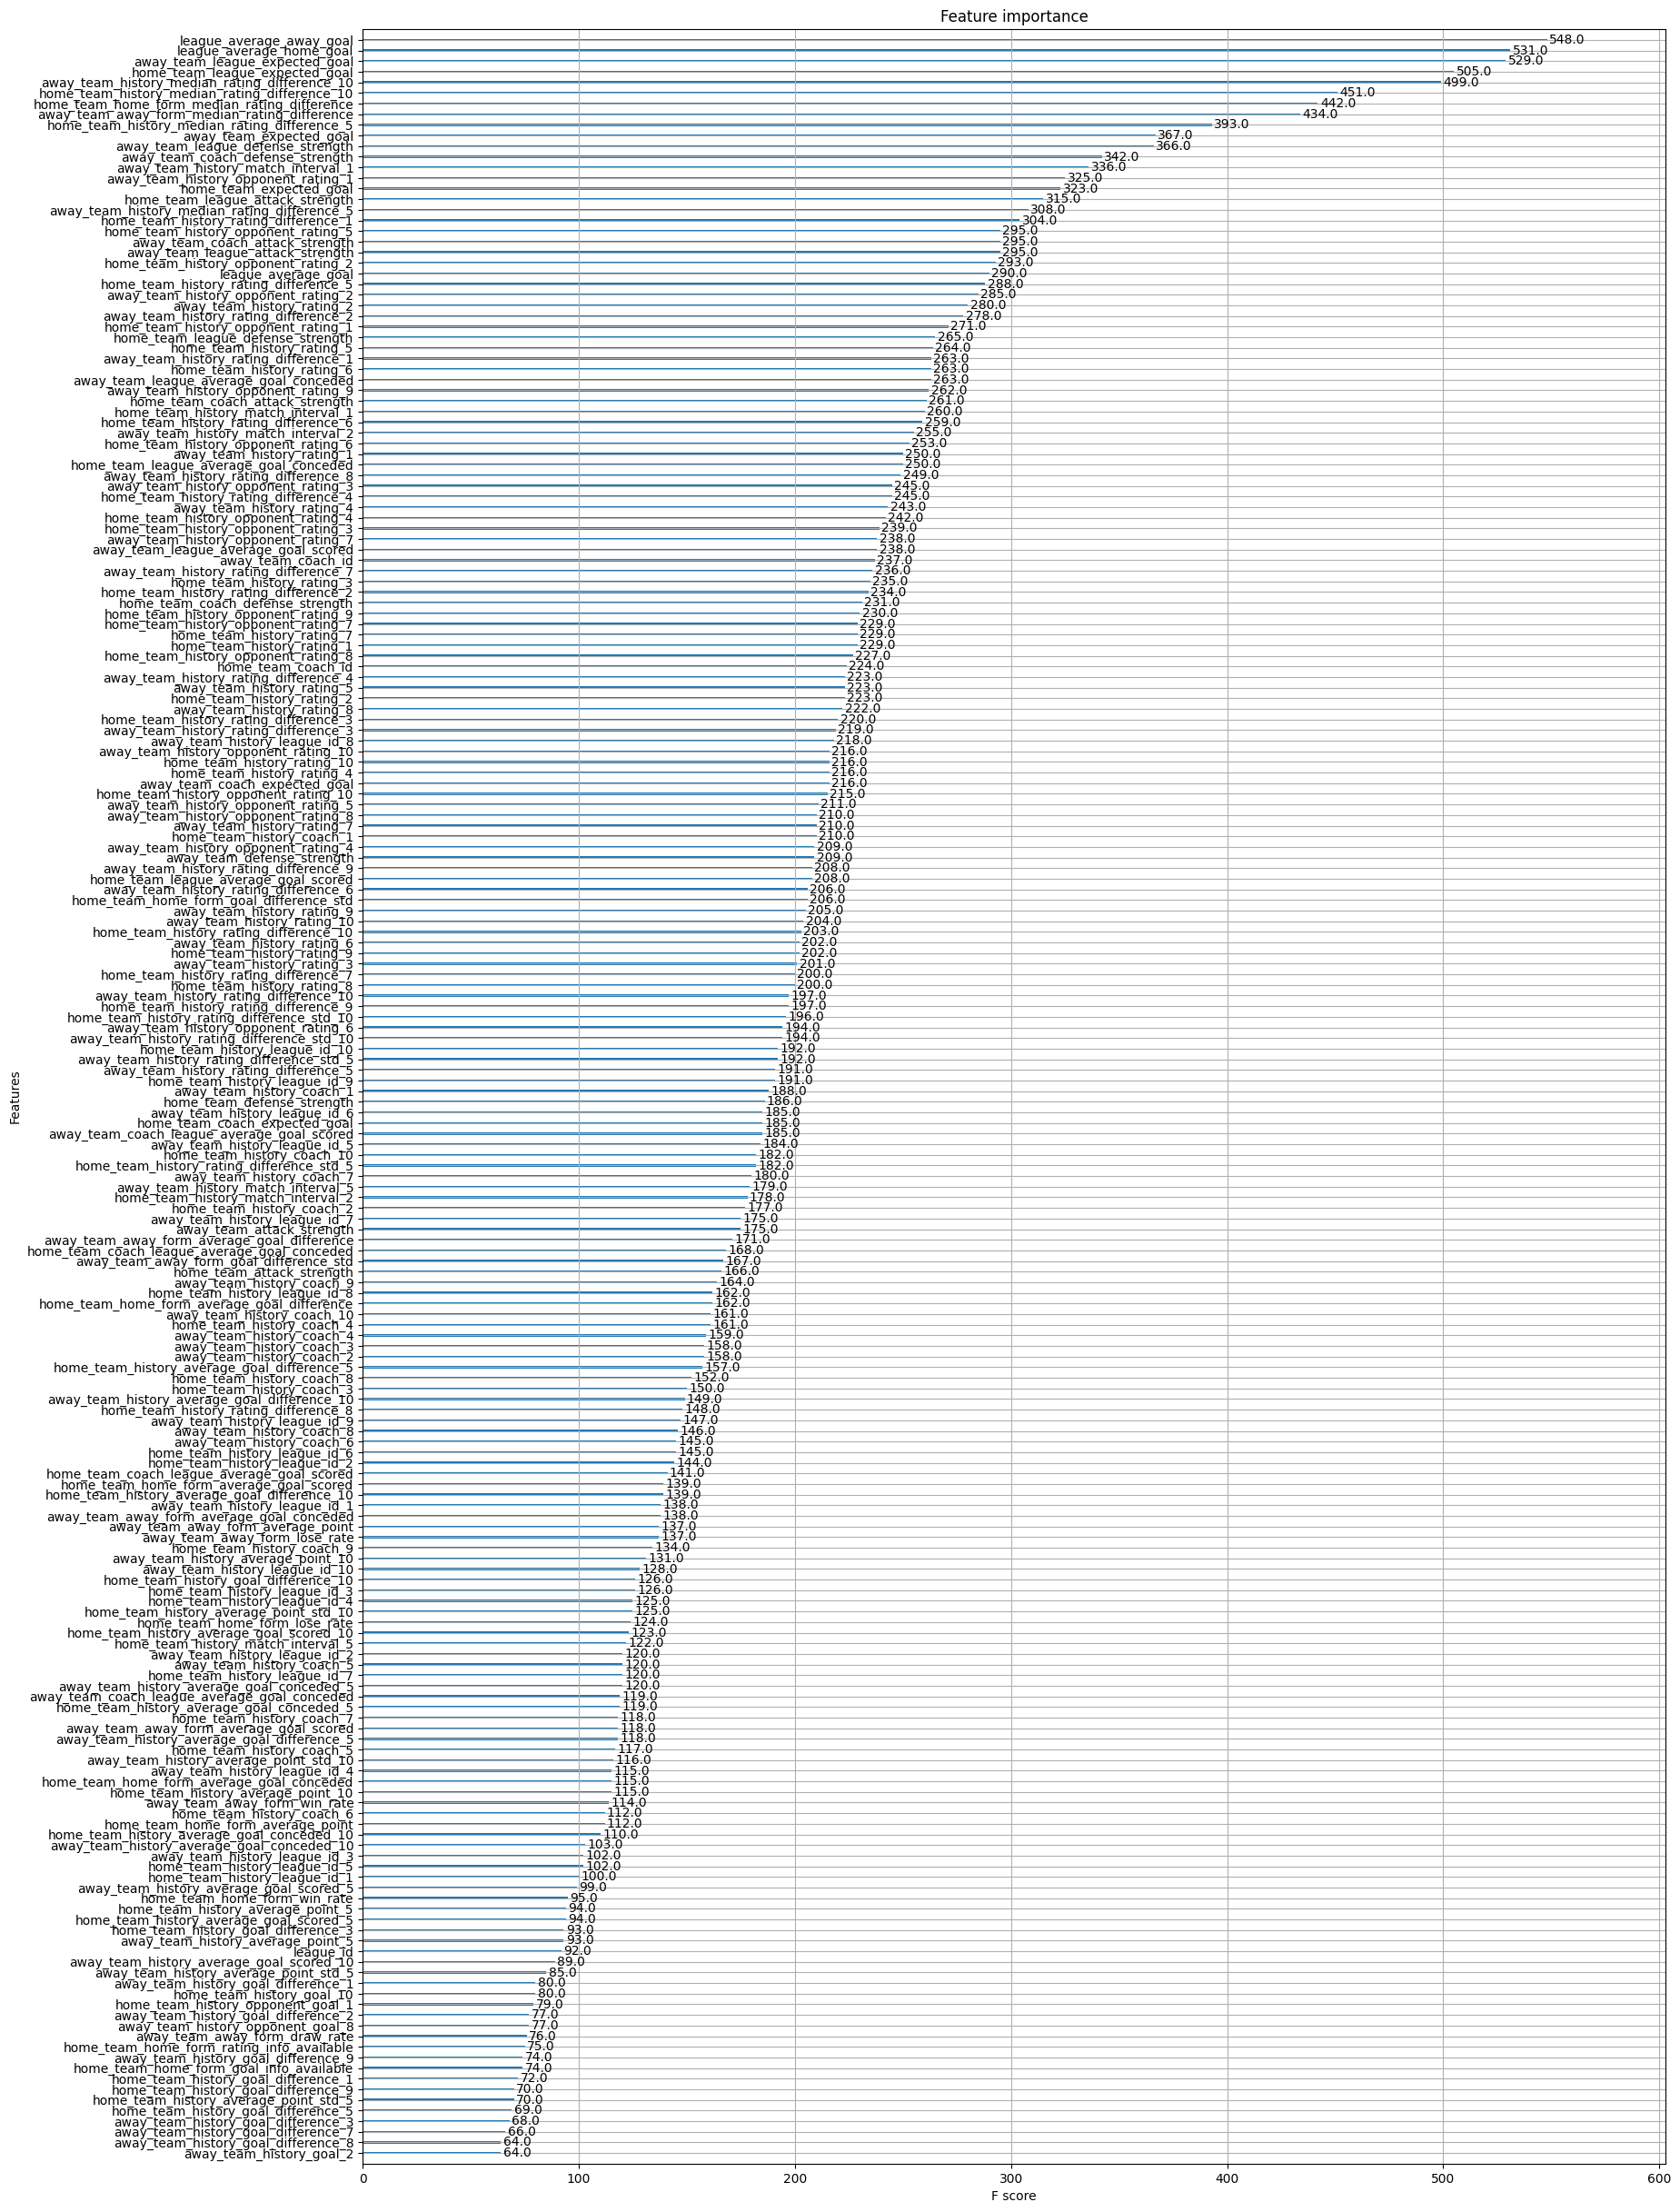

In [70]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

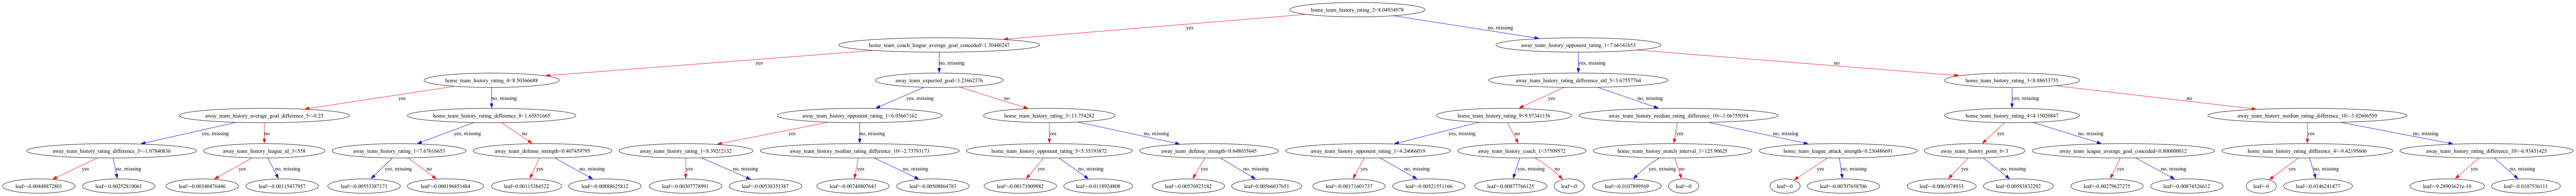

In [124]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(320, 200)
fig.savefig("xgb_tree_task1-2.png")

In [79]:
bst.best_iteration

448

In [80]:
bst.best_score

1.0053367216369378

In [87]:
X_test_d = xgb.DMatrix(X_test)

In [88]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [89]:
predictions

array([[0.7002057 , 0.16577283, 0.13402155],
       [0.04581488, 0.07589236, 0.87829274],
       [0.17039318, 0.15164177, 0.67796504],
       ...,
       [0.3551288 , 0.33302212, 0.3118491 ],
       [0.19280024, 0.2306674 , 0.57653236],
       [0.2702879 , 0.2351654 , 0.49454665]], dtype=float32)

Saving probabilities prediction into Task1_xgboost_submission.csv

In [90]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test.sort_values(by='id').reset_index()['id']
cols=['id','home','away','draw']
submission=submission[cols]
display(submission)

id      home      away      draw
0      11913628  0.134022  0.700206  0.165773
1      11913633  0.878293  0.045815  0.075892
2      11913634  0.677965  0.170393  0.151642
3      11913635  0.206527  0.610074  0.183399
4      11913636  0.101047  0.738790  0.160164
...         ...       ...       ...       ...
72706  18450343  0.179158  0.601585  0.219256
72707  18450597  0.356778  0.252318  0.390904
72708  18450602  0.311849  0.355129  0.333022
72709  18450640  0.576532  0.192800  0.230667
72710  18450641  0.494547  0.270288  0.235165

[72711 rows x 4 columns]

In [121]:
submission.to_csv('Task12_xgboost_submission.csv', index=False)